# Table of Contents

1. [Preprocessing the data](#preprocessing)
<br></br>
    1. [Importing libraries](#importing_lib)
    2. [Importing the dataset & descriptive characteristics](#importing_file)
    3. [NA values handling](#na_handling)
    4. [Weighted rating & top percentile choice](#weighted_rating)
    5. [Dataset dtype final review](#dtype_review)
    6. [Dummy variables for categorical](#dummy_cat)
<br></br>
2. [Fitting the classifiers](#fitting)
<br></br>
    1. [Sampling](#sampling)
    2. [Train-test split & scaling](#sample_traintest)
    3. [Classifier testing & kfolds](#classifier_testing)
    4. [Grid search & model save](#grid_search)
    5. [Applying best model to entire data](#model_entire_data)

## 1. Preprocessing the data <a name="preprocessing"></a>

#### 1. importing libraries <a name="importing_lib"></a>

In [33]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, plot_roc_curve, f1_score,  recall_score,
                             roc_auc_score, balanced_accuracy_score)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

----

#### 2. importing the file & descriptive characteristics of the dataset<a name="importing_file"></a>

In [34]:
#import the csv and save to df
df = pd.read_csv("Airbnb Berlin.csv")

C:\Users\nicolas.margos\AppData\Local\Temp\ipykernel_17700\2508494889.py:2: DtypeWarning: Columns (19,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Airbnb Berlin.csv")


In [35]:
# see the first 5 columns of the dataset
df.head()

,index,Review ID,review_date,Reviewer ID,Reviewer Name,Comments,Listing ID,Listing URL,Listing Name,Host ID,Host URL,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,City,Postal Code,Country Code,Country,Latitude,Longitude,Is Exact Location,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Square Feet,Price,Guests Included,Min Nights,Reviews,First Review,Last Review,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready
0,0,58660447.0,01-03-16,14876562.0,Dennis,"Very nice, clean appartement! Josh was really ...",10002699,https://www.airbnb.com/rooms/10002699,Trendy and peaceful KreuzkÃ¶lln,44696672,https://www.airbnb.com/users/show/44696672,Josh,09-20-15,NaN,NaN,f,NeukÃ¶lln,NeukÃ¶lln,Berlin,12047.0,DE,Germany,52.49234,13.42994,t,Apartment,Entire home/apt,4,1.0,2.0,2.0,NaN,60.0,1,1,1,01-03-16,01-03-16,100.0,8.0,10.0,6.0,10.0,10.0,10.0,f,f
1,1,NaN,NaN,NaN,NaN,NaN,10002922,https://www.airbnb.com/rooms/10002922,Sehr zentrale Wohnung in Berlin,45848709,https://www.airbnb.com/users/show/45848709,Belinda,10-05-15,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10405.0,DE,Germany,52.53292,13.41502,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,NaN,52.0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f
2,2,58663795.0,01-03-16,49367757.0,Andreea,Aki is really nice and friendly. We had an ama...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,https://www.airbnb.com/users/show/40791092,Arkadij,08-07-15,within a few hours,100%,f,Mitte,Mitte,Berlin,10178.0,DE,Germany,52.52134,13.41866,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,35.0,1,1,20,01-03-16,02-12-17,92.0,9.0,8.0,9.0,10.0,10.0,9.0,f,f
3,3,59003619.0,01-05-16,46694292.0,Sasha,Aki is a very nice dude with a clean place in ...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,https://www.airbnb.com/users/show/40791092,Arkadij,08-07-15,within a few hours,100%,f,Mitte,Mitte,Berlin,10178.0,DE,Germany,52.52134,13.41866,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,35.0,1,1,20,01-03-16,02-12-17,92.0,9.0,8.0,9.0,10.0,10.0,9.0,f,f
4,4,66845661.0,03-25-16,54542819.0,Yohana,Aki's place was easy to find and located in th...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,https://www.airbnb.com/users/show/40791092,Arkadij,08-07-15,within a few hours,100%,f,Mitte,Mitte,Berlin,10178.0,DE,Germany,52.52134,13.41866,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,35.0,1,1,20,01-03-16,02-12-17,92.0,9.0,8.0,9.0,10.0,10.0,9.0,f,f


In [36]:
#we see 47 columns so will use pd.set option to be able to see all columns with df head
df.info()
# square feet has too many na values so we kicked it out

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456961 entries, 0 to 456960
Data columns (total 47 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  456961 non-null  int64  
 1   Review ID              452805 non-null  float64
 2   review_date            452805 non-null  object 
 3   Reviewer ID            452805 non-null  float64
 4   Reviewer Name          452805 non-null  object 
 5   Comments               452597 non-null  object 
 6   Listing ID             456961 non-null  int64  
 7   Listing URL            456961 non-null  object 
 8   Listing Name           456756 non-null  object 
 9   Host ID                456961 non-null  int64  
 10  Host URL               456961 non-null  object 
 11  Host Name              456913 non-null  object 
 12  Host Since             456913 non-null  object 
 13  Host Response Time     398194 non-null  object 
 14  Host Response Rate     398194 non-nu

In [37]:
pd.set_option('display.max_columns', 150)
df.head()
#able to see first 5 rows of all columns now

,index,Review ID,review_date,Reviewer ID,Reviewer Name,Comments,Listing ID,Listing URL,Listing Name,Host ID,Host URL,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,City,Postal Code,Country Code,Country,Latitude,Longitude,Is Exact Location,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Square Feet,Price,Guests Included,Min Nights,Reviews,First Review,Last Review,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready
0,0,58660447.0,01-03-16,14876562.0,Dennis,"Very nice, clean appartement! Josh was really ...",10002699,https://www.airbnb.com/rooms/10002699,Trendy and peaceful KreuzkÃ¶lln,44696672,https://www.airbnb.com/users/show/44696672,Josh,09-20-15,NaN,NaN,f,NeukÃ¶lln,NeukÃ¶lln,Berlin,12047.0,DE,Germany,52.49234,13.42994,t,Apartment,Entire home/apt,4,1.0,2.0,2.0,NaN,60.0,1,1,1,01-03-16,01-03-16,100.0,8.0,10.0,6.0,10.0,10.0,10.0,f,f
1,1,NaN,NaN,NaN,NaN,NaN,10002922,https://www.airbnb.com/rooms/10002922,Sehr zentrale Wohnung in Berlin,45848709,https://www.airbnb.com/users/show/45848709,Belinda,10-05-15,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10405.0,DE,Germany,52.53292,13.41502,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,NaN,52.0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f
2,2,58663795.0,01-03-16,49367757.0,Andreea,Aki is really nice and friendly. We had an ama...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,https://www.airbnb.com/users/show/40791092,Arkadij,08-07-15,within a few hours,100%,f,Mitte,Mitte,Berlin,10178.0,DE,Germany,52.52134,13.41866,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,35.0,1,1,20,01-03-16,02-12-17,92.0,9.0,8.0,9.0,10.0,10.0,9.0,f,f
3,3,59003619.0,01-05-16,46694292.0,Sasha,Aki is a very nice dude with a clean place in ...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,https://www.airbnb.com/users/show/40791092,Arkadij,08-07-15,within a few hours,100%,f,Mitte,Mitte,Berlin,10178.0,DE,Germany,52.52134,13.41866,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,35.0,1,1,20,01-03-16,02-12-17,92.0,9.0,8.0,9.0,10.0,10.0,9.0,f,f
4,4,66845661.0,03-25-16,54542819.0,Yohana,Aki's place was easy to find and located in th...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,https://www.airbnb.com/users/show/40791092,Arkadij,08-07-15,within a few hours,100%,f,Mitte,Mitte,Berlin,10178.0,DE,Germany,52.52134,13.41866,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,35.0,1,1,20,01-03-16,02-12-17,92.0,9.0,8.0,9.0,10.0,10.0,9.0,f,f


In [38]:
# Keep a) neigbohrhood group, is exact location, property type, room type, accomodates, bathrooms, bedrooms,
# beds, square feet,price, ,min night, instant bookable, overall rating

---

#### 3. NA values handling<a name="na_handling"></a>

In [39]:
# get columns names
df.columns

Index(['index', 'Review ID', 'review_date', 'Reviewer ID', 'Reviewer Name',
       'Comments', 'Listing ID', 'Listing URL', 'Listing Name', 'Host ID',
       'Host URL', 'Host Name', 'Host Since', 'Host Response Time',
       'Host Response Rate', 'Is Superhost', 'neighbourhood',
       'Neighborhood Group', 'City', 'Postal Code', 'Country Code', 'Country',
       'Latitude', 'Longitude', 'Is Exact Location', 'Property Type',
       'Room Type', 'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds',
       'Square Feet', 'Price', 'Guests Included', 'Min Nights', 'Reviews',
       'First Review', 'Last Review', 'Overall Rating', 'Accuracy Rating',
       'Cleanliness Rating', 'Checkin Rating', 'Communication Rating',
       'Location Rating', 'Value Rating', 'Instant Bookable',
       'Business Travel Ready'],
      dtype='object')

In [40]:
#apply filter to keep only columns we want
df_filtered =df[["Neighborhood Group","Is Exact Location","Property Type",
    "Room Type","Accomodates","Bathrooms","Bedrooms","Beds","Reviews",
                 "Price","Min Nights","Overall Rating"]]

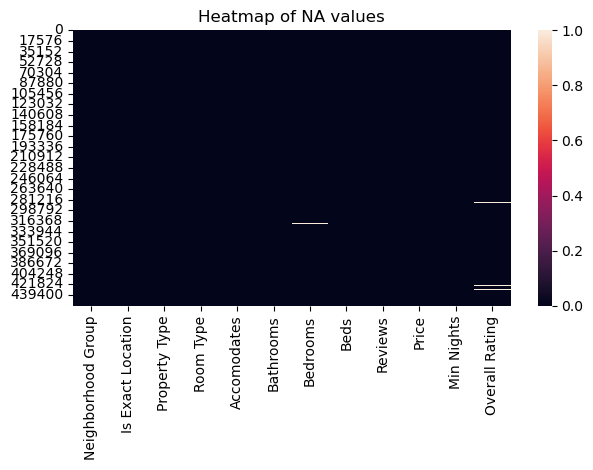

In [43]:
#visualize NA values as a heatmap
sns.heatmap(df_filtered.isna())
plt.title("Heatmap of NA values")
plt.xticks(rotation=90)
plt.tight_layout()
#plt.savefig("NA_values_heatmap.jpg") Uncomment to save the figure

In [10]:
df_filtered.isna().columns

Index(['Neighborhood Group', 'Is Exact Location', 'Property Type', 'Room Type',
       'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Reviews', 'Price',
       'Min Nights', 'Overall Rating'],
      dtype='object')

In [11]:
#find na values
df_filtered.isna().sum()

Neighborhood Group       0
Is Exact Location        0
Property Type            0
Room Type                0
Accomodates              0
Bathrooms              943
Bedrooms               717
Beds                    90
Reviews                  0
Price                    0
Min Nights               0
Overall Rating        4719
dtype: int64

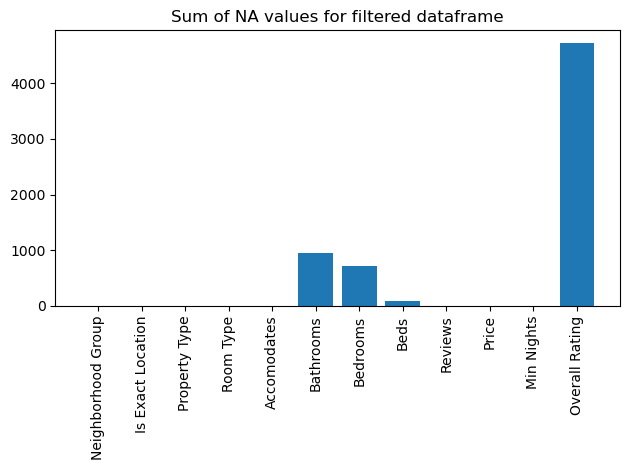

In [12]:
# visualize na values as bar plot
# use matplotlib to create the bar, denoting x and y column values
# add a title and rotate the x-axis or it will be unreadable
# add the command .tight_layout() in order for the export of the .savefig to not cut out the labels
plt.bar(df_filtered.isna().columns,df_filtered.isna().sum())
plt.title("Sum of NA values for filtered dataframe")
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig("NA_values_sum.jpg") uncomment to save the figure
plt.show()

#df_filtered.isna().sum().plot.bar()

In [13]:
#drop the na values
df_filtered.dropna(subset = ["Overall Rating","Bathrooms","Bedrooms","Beds"],inplace=True)

C:\Users\nicolas.margos\AppData\Local\Temp\ipykernel_17700\2783882207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset = ["Overall Rating","Bathrooms","Bedrooms","Beds"],inplace=True)


In [14]:
df_filtered.isna().sum()
#confirm if na has been dropped

Neighborhood Group    0
Is Exact Location     0
Property Type         0
Room Type             0
Accomodates           0
Bathrooms             0
Bedrooms              0
Beds                  0
Reviews               0
Price                 0
Min Nights            0
Overall Rating        0
dtype: int64

---

#### 4. Weighted rating creation for top percentile choice<a name="weighted_rating"></a>

In [15]:
# created a weighted rating to see the distribution of top percentile
df_filtered["Weighted_Rating"] = df_filtered["Reviews"] * df_filtered["Overall Rating"]

C:\Users\nicolas.margos\AppData\Local\Temp\ipykernel_17700\30922417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Weighted_Rating"] = df_filtered["Reviews"] * df_filtered["Overall Rating"]


In [16]:
# identify the cutoff point of >25 %, which is 14014
df_filtered["Weighted_Rating"].describe()

count    450557.000000
mean       9809.324711
std        9133.282524
min           0.000000
25%        2784.000000
50%        7144.000000
75%       14014.000000
max       50685.000000
Name: Weighted_Rating, dtype: float64

In [17]:
# check the Overall rating of the users that are in the top 25% of weighted rating. It appears that these users have a mean of 95% which is good for our diagnostic first look
df_filtered[df_filtered["Weighted_Rating"] > 14014]["Overall Rating"].describe()

count    112548.000000
mean         94.602223
std           3.226336
min          80.000000
25%          92.000000
50%          95.000000
75%          97.000000
max         100.000000
Name: Overall Rating, dtype: float64

In [18]:
#view a few quick descriptive characteristics of those above 14014
df_filtered[df_filtered["Weighted_Rating"] > 14014]["Price"].describe()

count     112548.0
unique       181.0
top           35.0
freq        2825.0
Name: Price, dtype: float64

In [19]:
# create the target column to predict, whereas values in the top 25% are given label 1

df_filtered["Is Top Percentile"] =df_filtered["Weighted_Rating"].apply(lambda x: 1 if x >14014 else 0)

C:\Users\nicolas.margos\AppData\Local\Temp\ipykernel_17700\2553683139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Is Top Percentile"] =df_filtered["Weighted_Rating"].apply(lambda x: 1 if x >14014 else 0)


In [20]:
df_filtered.head(5)

,Neighborhood Group,Is Exact Location,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Reviews,Price,Min Nights,Overall Rating,Weighted_Rating,Is Top Percentile
0,NeukÃ¶lln,t,Apartment,Entire home/apt,4,1.0,2.0,2.0,1,60.0,1,100.0,100.0,0
2,Mitte,t,Apartment,Private room,2,1.0,1.0,1.0,20,35.0,1,92.0,1840.0,0
3,Mitte,t,Apartment,Private room,2,1.0,1.0,1.0,20,35.0,1,92.0,1840.0,0
4,Mitte,t,Apartment,Private room,2,1.0,1.0,1.0,20,35.0,1,92.0,1840.0,0
5,Mitte,t,Apartment,Private room,2,1.0,1.0,1.0,20,35.0,1,92.0,1840.0,0


In [21]:
#view the distribution of label 1 vs label 0, we can view that label 0 has approximately 3 times the size of label 1
df_filtered["Is Top Percentile"].value_counts()

0    338009
1    112548
Name: Is Top Percentile, dtype: int64

In [115]:
df_filtered["Is Top Percentile"].unique()

array([0, 1], dtype=int64)

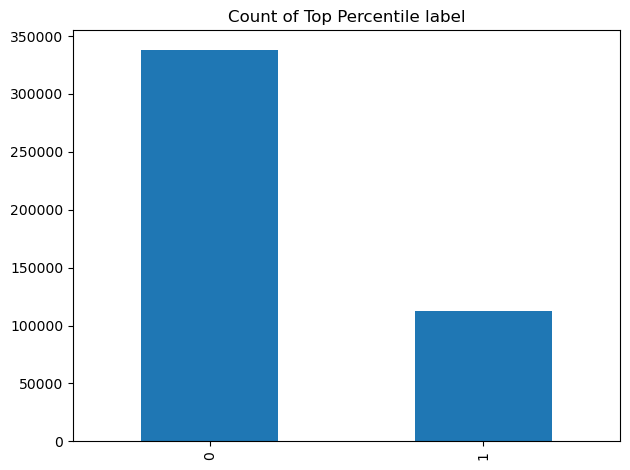

In [22]:

df_filtered["Is Top Percentile"].value_counts().plot(kind="bar")
plt.title("Count of Top Percentile label")
plt.xticks(rotation=90)
plt.tight_layout()
#plt.savefig("Top_Percentile_Count.jpg") uncomment to save the figure
plt.show()

#df_filtered.isna().sum().plot.bar()

NameError: name 'plt' is not defined

In [26]:
#drop the reviews, overall rating, weighted rating as this wont be used to influence the final prediciton when we have new data to predict
df_filtered.drop(["Reviews","Overall Rating","Weighted_Rating"],axis=1,inplace=True)

C:\Users\nicolas.margos\AppData\Local\Temp\ipykernel_23836\3504494005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(["Reviews","Overall Rating","Weighted_Rating"],axis=1,inplace=True)


In [27]:
df_filtered.head()

,Neighborhood Group,Is Exact Location,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Price,Min Nights,Is Top Percentile
0,NeukÃ¶lln,t,Apartment,Entire home/apt,4,1.0,2.0,2.0,60.0,1,0
2,Mitte,t,Apartment,Private room,2,1.0,1.0,1.0,35.0,1,0
3,Mitte,t,Apartment,Private room,2,1.0,1.0,1.0,35.0,1,0
4,Mitte,t,Apartment,Private room,2,1.0,1.0,1.0,35.0,1,0
5,Mitte,t,Apartment,Private room,2,1.0,1.0,1.0,35.0,1,0


---

#### 5. Dataset dtype final review <a name="dtype_review"></a>

In [28]:
#check the dtype of the processed dataset, observe price is an object vs a float
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450557 entries, 0 to 456960
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Neighborhood Group  450557 non-null  object 
 1   Is Exact Location   450557 non-null  object 
 2   Property Type       450557 non-null  object 
 3   Room Type           450557 non-null  object 
 4   Accomodates         450557 non-null  int64  
 5   Bathrooms           450557 non-null  float64
 6   Bedrooms            450557 non-null  float64
 7   Beds                450557 non-null  float64
 8   Price               450557 non-null  object 
 9   Min Nights          450557 non-null  int64  
 10  Is Top Percentile   450557 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 41.2+ MB


In [29]:
#apply format to price to make it into float (if you first run the command astype you will get an error due to the existence of / in a value)
#must first replace the "\"
df_filtered["Price"]=df_filtered["Price"].replace("\,","",regex=True)

C:\Users\nicolas.margos\AppData\Local\Temp\ipykernel_23836\955550498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Price"]=df_filtered["Price"].replace("\,","",regex=True)


In [30]:
#can now turn the price into a float dtype
df_filtered["Price"]=df_filtered["Price"].astype(float)

C:\Users\nicolas.margos\AppData\Local\Temp\ipykernel_23836\3677132002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Price"]=df_filtered["Price"].astype(float)


In [31]:
df.info() #final check of dtypes

---

#### 6. Dummy variables for categorical <a name="dummy_cat"></a>

In [32]:
# get dummies for categorical
df_filtered=pd.get_dummies(df_filtered,drop_first=True)

In [33]:
#df_filtered.info()

In [34]:
# roughly three times the amount of labels 0 vs label 1
df_filtered["Is Top Percentile"].value_counts()

0    338009
1    112548
Name: Is Top Percentile, dtype: int64

-----

## 2. Fitting the classifiers<a name="fitting"></a>


#### 7. Sampling<a name="sampling"></a>

In [35]:
### checking the results of the filtered dataset (with categorical variables)
df_filtered.head()

,Accomodates,Bathrooms,Bedrooms,Beds,Price,Min Nights,Is Top Percentile,Neighborhood Group_Friedrichshain-Kreuzberg,Neighborhood Group_Lichtenberg,Neighborhood Group_Marzahn - Hellersdorf,Neighborhood Group_Mitte,Neighborhood Group_NeukÃ¶lln,Neighborhood Group_Pankow,Neighborhood Group_Reinickendorf,Neighborhood Group_Spandau,Neighborhood Group_Steglitz - Zehlendorf,Neighborhood Group_Tempelhof - SchÃ¶neberg,Neighborhood Group_Treptow - KÃ¶penick,Is Exact Location_t,Property Type_Apartment,Property Type_Barn,Property Type_Bed and breakfast,Property Type_Boat,Property Type_Boutique hotel,Property Type_Bungalow,Property Type_Cabin,Property Type_Camper/RV,Property Type_Casa particular (Cuba),Property Type_Castle,Property Type_Cave,Property Type_Condominium,Property Type_Cottage,Property Type_Earth house,Property Type_Guest suite,Property Type_Guesthouse,Property Type_Hostel,Property Type_Hotel,Property Type_House,Property Type_Houseboat,Property Type_Hut,Property Type_Loft,Property Type_Other,Property Type_Pension (South Korea),Property Type_Resort,Property Type_Serviced apartment,Property Type_Tent,Property Type_Tiny house,Property Type_Tipi,Property Type_Townhouse,Property Type_Train,Property Type_Treehouse,Property Type_Villa,Room Type_Private room,Room Type_Shared room
0,4,1.0,2.0,2.0,60.0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1.0,1.0,1.0,35.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2,1.0,1.0,1.0,35.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,1.0,1.0,1.0,35.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,2,1.0,1.0,1.0,35.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [36]:
# dataset has ~450k rows, will first run the algorithms with a sample for faster processing
# Take a sample of 11000

df_sample=df_filtered.sample(n=30000, frac=None, replace=False, weights=None, random_state=42, axis=None, ignore_index=False)


---

#### 8. Train-test split and scaling<a name="sample_traintest"></a>

In [37]:
# choosing the label as y, and the features as x
X = df_sample.drop("Is Top Percentile",axis=1)


y = df_sample["Is Top Percentile"]

In [46]:
# splitting into train and test with a test size of 25%
# shuffle set to True to avoid obtaining an overrepresentation of certain areas or features in the train vs test should the dataset be in order of neighborhoods for example or any other feature
# stratify set to y based on the uneven representation of label 0 vs label 1 (remember label 0 is ~3 times more than 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y,shuffle=True)

In [47]:
# importing a standard scaler
ss = StandardScaler()

In [48]:
# fit transforming the training data set
# using the command pd.DataFrame so the output can be a transformed dataframe
X_train = pd.DataFrame(ss.fit_transform(X_train),columns=X.columns)

In [49]:
# only transforming the test data set since we have the train distribution parameters from the fit command
X_test = pd.DataFrame(ss.transform(X_test),columns = X.columns)

---

#### 9. Classifier testing and kfolds<a name="classifier_testing"></a>

In [51]:
# creating a list named classifiers that will contain 4 different classifiers to test performance.
# SVC was commented out retroactively due to the immense time it took to run
# class weight balanced
classifiers = [
          LogisticRegression(class_weight="balanced",max_iter=10000), 
          #SVC(class_weight="balanced"), 
          GaussianNB(),KNeighborsClassifier()]

In [52]:
# arbitrary choice of 5 splits for a more fair assesment and save it to the variable cv
cv=KFold(n_splits=5)

In [53]:
# tqdm used to ensure the loop below is not stuck and to asses time to run
# for every classifier in the list classifiers:
# we fit the training features and labels
# we print out the name of the classifier and the text training scores to be able to follow the output
# we save the recall score using cross validation on the recall metric and using the 5 splits from variable cv
# we print out the name of the classifier and the recall score
# repeat the above steps for the f1 and balanced accuracy score
# we then save the prediction for the testing features into a variable named class pred
# we output the classification report for the testing features and predictions to establish the best performing mode
# K Neighbors has the best scores with a recall of 0.95 for label 1 
for classifier in tqdm(classifiers):
    classifier.fit(X_train,y_train)
    print(classifier,"Training scores")
    recall_score = cross_val_score(classifier,X_train,y_train,cv=cv,scoring="recall")
    print(classifier, f"Recall score : {round(recall_score.mean(),2)}")
    f1_score = cross_val_score(classifier,X_train,y_train,cv=cv,scoring="f1")
    print(classifier, f"f1 score : {round(f1_score.mean(),2)}")
    baccuracy_score = cross_val_score(classifier,X_train,y_train,cv=cv,scoring="balanced_accuracy")
    print(classifier, f"Balanced accuracy score : {round(baccuracy_score.mean(),2)}")
    print()
    class_pred=classifier.predict(X_test)
    print("Test classification report:")
    print(classification_report(y_test,class_pred))
    print()
    print()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

LogisticRegression(class_weight='balanced', max_iter=10000) Training scores
LogisticRegression(class_weight='balanced', max_iter=10000) Recall score : 0.67
LogisticRegression(class_weight='balanced', max_iter=10000) f1 score : 0.44


 33%|████████████████████████████                                                        | 1/3 [00:03<00:07,  3.94s/it]

LogisticRegression(class_weight='balanced', max_iter=10000) Balanced accuracy score : 0.6

Test classification report:
              precision    recall  f1-score   support

           0       0.83      0.53      0.65      5626
           1       0.32      0.68      0.44      1874

    accuracy                           0.57      7500
   macro avg       0.58      0.60      0.54      7500
weighted avg       0.70      0.57      0.60      7500



GaussianNB() Training scores
GaussianNB() Recall score : 1.0
GaussianNB() f1 score : 0.41


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:01,  1.97s/it]

GaussianNB() Balanced accuracy score : 0.52

Test classification report:
              precision    recall  f1-score   support

           0       1.00      0.03      0.06      5626
           1       0.26      1.00      0.41      1874

    accuracy                           0.27      7500
   macro avg       0.63      0.52      0.23      7500
weighted avg       0.81      0.27      0.15      7500



KNeighborsClassifier() Training scores
KNeighborsClassifier() Recall score : 0.94
KNeighborsClassifier() f1 score : 0.87
KNeighborsClassifier() Balanced accuracy score : 0.93



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.09s/it]

Test classification report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5626
           1       0.83      0.95      0.89      1874

    accuracy                           0.94      7500
   macro avg       0.91      0.94      0.92      7500
weighted avg       0.95      0.94      0.94      7500





In [ ]:
# we explore the logistic regression model with a train and a test classification report (applying similar steps to the cell above)
# both classification reports show a much weaker report than KNeighborsClassifier

In [54]:
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X_train,y_train)
log_train_predict = logreg.predict(X_train)
log_test_predict = logreg.predict(X_test)
print("Train classification report: ")
print(classification_report(y_train,log_train_predict))
print("Test classification report: ")
print(classification_report(y_test,log_test_predict))

Train classification report: 
              precision    recall  f1-score   support

           0       0.83      0.54      0.65     16879
           1       0.33      0.67      0.44      5621

    accuracy                           0.57     22500
   macro avg       0.58      0.61      0.55     22500
weighted avg       0.71      0.57      0.60     22500

Test classification report: 
              precision    recall  f1-score   support

           0       0.83      0.53      0.65      5626
           1       0.32      0.68      0.44      1874

    accuracy                           0.57      7500
   macro avg       0.58      0.60      0.54      7500
weighted avg       0.70      0.57      0.60      7500



In [ ]:
# we apply KNeighbors with a train and test classification report, choosing an arbitrary n_neighbors of 3
# we validate the high performance of the recall score

In [55]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
knn_train_predict = knn.predict(X_train)
knn_test_predict = knn.predict(X_test)
print("Train classification report: ")
print(classification_report(y_train,knn_train_predict))
print("Test classification report: ")
print(classification_report(y_test,knn_test_predict))

Train classification report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     16879
           1       0.92      0.95      0.93      5621

    accuracy                           0.97     22500
   macro avg       0.95      0.96      0.96     22500
weighted avg       0.97      0.97      0.97     22500

Test classification report: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5626
           1       0.87      0.94      0.91      1874

    accuracy                           0.95      7500
   macro avg       0.93      0.95      0.94      7500
weighted avg       0.95      0.95      0.95      7500



In [ ]:
# we dive further into the KNeigborsClassifier by testing performance with a different number of neighbors

In [56]:
# we initiate a loop to test number of neighbors 1-4
# we print the loop name, and fit the KNeighborsClassifier with the value of i which is the current iteration
# we predict the perfomrance of the test
# we print the classification report
# we end up with 4 different classification report for 4 different KneighborClassifiers with number of neighbors equal to 1-4
#neighbors = 3 appears to have best metrics, with very high recall for label =1
for i in range(1,5):
    print("for neighbors i equal to = ",i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    #knn_train_predict = knn.predict(X_train)
    knn_test_predict = knn.predict(X_test)
    #print("Train classification report: ")
    #print(classification_report(y_train,knn_train_predict))
    print("Test classification report: ")
    print(classification_report(y_test,knn_test_predict))

for neighbors i equal to =  1
Test classification report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5626
           1       0.90      0.93      0.92      1874

    accuracy                           0.96      7500
   macro avg       0.94      0.95      0.94      7500
weighted avg       0.96      0.96      0.96      7500

for neighbors i equal to =  2
Test classification report: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5626
           1       0.93      0.89      0.91      1874

    accuracy                           0.96      7500
   macro avg       0.95      0.93      0.94      7500
weighted avg       0.95      0.96      0.96      7500

for neighbors i equal to =  3
Test classification report: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5626
           1       0.87      0.94      0.91      1874

    a

---

#### 10. Grid Search and model save<a name="gridsearch"></a>

In [59]:
#what if the best performing neighbor is a higher value than 4?
# for this case we will create a list of values from 1-30 and save it to variable k_range
k_range = list(range(1, 31))

In [67]:
# we will also create a variable named weight_options which will contain two different options for the Kneighbors classifier parameter
weight_options = ['uniform', 'distance']

In [74]:
#creating a leaves size option as well with values 1-39 and saving it to leaves size variable
leaves_sizes = list(range(1,40))

In [68]:
# creating a dictionary that will contain the variables k_range, weights options . 
# We will not use the leaves_sizes variable now to reduce running time
param_grid = dict(n_neighbors=k_range,weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [69]:
#initiating a grid search for the combination of n_neighbors and weights. This will run the algorithm with all combinations of both parameters.
grid = GridSearchCV(knn, param_grid, cv=5, scoring='recall',verbose=2)

In [70]:
#fitting the grid and observing the outcome which is available from verbose =2
grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.2s
[CV] END .....................n_neighbors=2, we

[CV] END ....................n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END ....................n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END ....................n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END ....................n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END ...................n_neighbors=11, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=11, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=11, weights=distance; total time=   0.2s
[CV] END ...................n_neighbors=11, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=11, weights=distance; total time=   0.1s
[CV] END ....................n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END ....................n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END ....................n_neighbors=12, weights=uniform; total time=   0.2s
[CV] END ...................

[CV] END ....................n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ....................n_neighbors=21, weights=uniform; total time=   0.3s
[CV] END ...................n_neighbors=21, weights=distance; total time=   0.2s
[CV] END ...................n_neighbors=21, weights=distance; total time=   0.3s
[CV] END ...................n_neighbors=21, weights=distance; total time=   0.3s
[CV] END ...................n_neighbors=21, weights=distance; total time=   0.2s
[CV] END ...................n_neighbors=21, weights=distance; total time=   0.2s
[CV] END ....................n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ....................n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ....................n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ....................n_neighbors=22, weights=uniform; total time=   0.3s
[CV] END ....................n_neighbors=22, weights=uniform; total time=   0.3s
[CV] END ...................

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=4),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='recall', verbose=2)

In [71]:
#after the fit is done we obtain the best parameters
print(grid.best_params_)

{'n_neighbors': 19, 'weights': 'distance'}


In [72]:
print(grid.best_estimator_)

KNeighborsClassifier(n_neighbors=19, weights='distance')


In [73]:
#printing a classification report which shows the recall for 1 is 0.96
print(classification_report(y_test,grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5626
           1       0.88      0.96      0.92      1874

    accuracy                           0.96      7500
   macro avg       0.93      0.96      0.94      7500
weighted avg       0.96      0.96      0.96      7500



In [77]:
# save the model to disk
filename = 'knn_supervised_model_19neighbors_v1.sav'
pickle.dump(grid, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)

In [78]:
#initiating a new param grid, this time addive leaves_sizes
param_grid = dict(n_neighbors=k_range,weights=weight_options,leaf_size=leaves_sizes)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance'], 'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]}


In [79]:
#initiating a new grid search
grid = GridSearchCV(knn, param_grid, cv=5, scoring='recall',verbose=2)

In [80]:
#fitting the new grid
grid.fit(X_train, y_train)

Fitting 5 folds for each of 2340 candidates, totalling 11700 fits
[CV] END ........leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END ........leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END ........leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END ........leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END ........leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END .......leaf_size=1, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END .......leaf_size=1, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END .......leaf_size=1, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END .......leaf_size=1, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END .......leaf_size=1, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ........leaf_size=1, n_neighbors=2, weights=uniform; total time=   0.2s
[CV] END ........leaf_size=1, n_neighbors=2

[CV] END .......leaf_size=1, n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=1, n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=1, n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=1, n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=1, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END ......leaf_size=1, n_neighbors=11, weights=distance; total time=   0.1s
[CV] END ......leaf_size=1, n_neighbors=11, weights=distance; total time=   0.1s
[CV] END ......leaf_size=1, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END ......leaf_size=1, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .......leaf_size=1, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=1, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=1, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=1,

[CV] END .......leaf_size=1, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=1, n_neighbors=21, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=1, n_neighbors=21, weights=distance; total time=   0.1s
[CV] END ......leaf_size=1, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END ......leaf_size=1, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END ......leaf_size=1, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END ......leaf_size=1, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END .......leaf_size=1, n_neighbors=22, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=1, n_neighbors=22, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=1, n_neighbors=22, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=1, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=1, n_neighbors=22, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=1, 

[CV] END .......leaf_size=2, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END .......leaf_size=2, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END .......leaf_size=2, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END .......leaf_size=2, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ........leaf_size=2, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=2, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=2, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=2, n_neighbors=2, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=2, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=2, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END .......leaf_size=2, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END .......leaf_size=2, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END .......leaf_size=2,

[CV] END ......leaf_size=2, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END ......leaf_size=2, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .......leaf_size=2, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=2, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=2, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=2, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=2, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=2, n_neighbors=12, weights=distance; total time=   0.1s
[CV] END ......leaf_size=2, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END ......leaf_size=2, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END ......leaf_size=2, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END ......leaf_size=2, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .......leaf_size=2,

[CV] END .......leaf_size=2, n_neighbors=22, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=2, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=2, n_neighbors=22, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=2, n_neighbors=22, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=2, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=2, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END ......leaf_size=2, n_neighbors=22, weights=distance; total time=   0.3s
[CV] END ......leaf_size=2, n_neighbors=22, weights=distance; total time=   0.3s
[CV] END ......leaf_size=2, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END ......leaf_size=2, n_neighbors=22, weights=distance; total time=   0.3s
[CV] END .......leaf_size=2, n_neighbors=23, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=2, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=2,

[CV] END ........leaf_size=3, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=3, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=3, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=3, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END .......leaf_size=3, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END .......leaf_size=3, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END .......leaf_size=3, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END .......leaf_size=3, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END ........leaf_size=3, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=3, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=3, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=3, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=3

[CV] END .......leaf_size=3, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=3, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END ......leaf_size=3, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END ......leaf_size=3, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END ......leaf_size=3, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END ......leaf_size=3, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .......leaf_size=3, n_neighbors=13, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=3, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=3, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=3, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=3, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=3, n_neighbors=13, weights=distance; total time=   0.1s
[CV] END ......leaf_size=3, 

[CV] END ......leaf_size=3, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END ......leaf_size=3, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END ......leaf_size=3, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END ......leaf_size=3, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .......leaf_size=3, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=3, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=3, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=3, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=3, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=3, n_neighbors=23, weights=distance; total time=   0.3s
[CV] END ......leaf_size=3, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END ......leaf_size=3, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END ......leaf_size=3, 

[CV] END .......leaf_size=4, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END .......leaf_size=4, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END ........leaf_size=4, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=4, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=4, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=4, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=4, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=4, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .......leaf_size=4, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .......leaf_size=4, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .......leaf_size=4, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END .......leaf_size=4, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ........leaf_size=4

[CV] END .......leaf_size=4, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=4, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=4, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=4, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=4, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=4, n_neighbors=13, weights=distance; total time=   0.1s
[CV] END ......leaf_size=4, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END ......leaf_size=4, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END ......leaf_size=4, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END ......leaf_size=4, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .......leaf_size=4, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=4, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=4,

[CV] END .......leaf_size=4, n_neighbors=23, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=4, n_neighbors=23, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=4, n_neighbors=23, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=4, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END ......leaf_size=4, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END ......leaf_size=4, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END ......leaf_size=4, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END ......leaf_size=4, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .......leaf_size=4, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=4, n_neighbors=24, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=4, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=4, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=4,

[CV] END ........leaf_size=5, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=5, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .......leaf_size=5, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .......leaf_size=5, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .......leaf_size=5, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .......leaf_size=5, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ........leaf_size=5, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=5, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=5, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=5, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=5, n_neighbors=4, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=5, n_neighbors=4, weights=distance; total time=   0.1s
[CV] END .......leaf_size=5,

[CV] END ......leaf_size=5, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END ......leaf_size=5, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END ......leaf_size=5, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END ......leaf_size=5, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .......leaf_size=5, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=5, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=5, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=5, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=5, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=5, n_neighbors=14, weights=distance; total time=   0.1s
[CV] END ......leaf_size=5, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END ......leaf_size=5, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END ......leaf_size=5, 

[CV] END ......leaf_size=5, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END ......leaf_size=5, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .......leaf_size=5, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=5, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=5, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=5, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=5, n_neighbors=24, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=5, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END ......leaf_size=5, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END ......leaf_size=5, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END ......leaf_size=5, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END ......leaf_size=5, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END .......leaf_size=5,

[CV] END ........leaf_size=6, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=6, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=6, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=6, n_neighbors=4, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=6, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=6, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END .......leaf_size=6, n_neighbors=4, weights=distance; total time=   0.1s
[CV] END .......leaf_size=6, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END .......leaf_size=6, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END .......leaf_size=6, n_neighbors=4, weights=distance; total time=   0.1s
[CV] END ........leaf_size=6, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=6, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=6

[CV] END .......leaf_size=6, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=6, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=6, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=6, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END ......leaf_size=6, n_neighbors=14, weights=distance; total time=   0.3s
[CV] END ......leaf_size=6, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END ......leaf_size=6, n_neighbors=14, weights=distance; total time=   0.3s
[CV] END ......leaf_size=6, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END .......leaf_size=6, n_neighbors=15, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=6, n_neighbors=15, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=6, n_neighbors=15, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=6, n_neighbors=15, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=6,

[CV] END .......leaf_size=6, n_neighbors=24, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=6, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END ......leaf_size=6, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END ......leaf_size=6, n_neighbors=24, weights=distance; total time=   0.3s
[CV] END ......leaf_size=6, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END ......leaf_size=6, n_neighbors=24, weights=distance; total time=   0.3s
[CV] END .......leaf_size=6, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=6, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=6, n_neighbors=25, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=6, n_neighbors=25, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=6, n_neighbors=25, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=6, n_neighbors=25, weights=distance; total time=   0.3s
[CV] END ......leaf_size=6, 

[CV] END .......leaf_size=7, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END .......leaf_size=7, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END .......leaf_size=7, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END .......leaf_size=7, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ........leaf_size=7, n_neighbors=5, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=7, n_neighbors=5, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=7, n_neighbors=5, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=7, n_neighbors=5, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=7, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=7, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END .......leaf_size=7, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END .......leaf_size=7, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END .......leaf_size=7,

[CV] END ......leaf_size=7, n_neighbors=14, weights=distance; total time=   0.3s
[CV] END ......leaf_size=7, n_neighbors=14, weights=distance; total time=   0.3s
[CV] END .......leaf_size=7, n_neighbors=15, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=7, n_neighbors=15, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=7, n_neighbors=15, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=7, n_neighbors=15, weights=uniform; total time=   0.6s
[CV] END .......leaf_size=7, n_neighbors=15, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=7, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END ......leaf_size=7, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END ......leaf_size=7, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END ......leaf_size=7, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END ......leaf_size=7, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END .......leaf_size=7,

[CV] END .......leaf_size=7, n_neighbors=25, weights=uniform; total time=   0.6s
[CV] END .......leaf_size=7, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=7, n_neighbors=25, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=7, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=7, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=7, n_neighbors=25, weights=distance; total time=   0.3s
[CV] END ......leaf_size=7, n_neighbors=25, weights=distance; total time=   0.3s
[CV] END ......leaf_size=7, n_neighbors=25, weights=distance; total time=   0.3s
[CV] END ......leaf_size=7, n_neighbors=25, weights=distance; total time=   0.2s
[CV] END ......leaf_size=7, n_neighbors=25, weights=distance; total time=   0.3s
[CV] END .......leaf_size=7, n_neighbors=26, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=7, n_neighbors=26, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=7,

[CV] END ........leaf_size=8, n_neighbors=5, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=8, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=8, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=8, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END .......leaf_size=8, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END .......leaf_size=8, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END .......leaf_size=8, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END .......leaf_size=8, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END ........leaf_size=8, n_neighbors=6, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=8, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=8, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=8, n_neighbors=6, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=8

[CV] END .......leaf_size=8, n_neighbors=15, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=8, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END ......leaf_size=8, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END ......leaf_size=8, n_neighbors=15, weights=distance; total time=   0.3s
[CV] END ......leaf_size=8, n_neighbors=15, weights=distance; total time=   0.3s
[CV] END ......leaf_size=8, n_neighbors=15, weights=distance; total time=   0.3s
[CV] END .......leaf_size=8, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=8, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=8, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=8, n_neighbors=16, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=8, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=8, n_neighbors=16, weights=distance; total time=   0.2s
[CV] END ......leaf_size=8, 

[CV] END ......leaf_size=8, n_neighbors=25, weights=distance; total time=   0.3s
[CV] END ......leaf_size=8, n_neighbors=25, weights=distance; total time=   0.3s
[CV] END ......leaf_size=8, n_neighbors=25, weights=distance; total time=   0.3s
[CV] END ......leaf_size=8, n_neighbors=25, weights=distance; total time=   0.3s
[CV] END .......leaf_size=8, n_neighbors=26, weights=uniform; total time=   0.6s
[CV] END .......leaf_size=8, n_neighbors=26, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=8, n_neighbors=26, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=8, n_neighbors=26, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=8, n_neighbors=26, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=8, n_neighbors=26, weights=distance; total time=   0.2s
[CV] END ......leaf_size=8, n_neighbors=26, weights=distance; total time=   0.3s
[CV] END ......leaf_size=8, n_neighbors=26, weights=distance; total time=   0.3s
[CV] END ......leaf_size=8, 

[CV] END .......leaf_size=9, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END .......leaf_size=9, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END ........leaf_size=9, n_neighbors=6, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=9, n_neighbors=6, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=9, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ........leaf_size=9, n_neighbors=6, weights=uniform; total time=   0.4s
[CV] END ........leaf_size=9, n_neighbors=6, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=9, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END .......leaf_size=9, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END .......leaf_size=9, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END .......leaf_size=9, n_neighbors=6, weights=distance; total time=   0.3s
[CV] END .......leaf_size=9, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ........leaf_size=9

[CV] END .......leaf_size=9, n_neighbors=16, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=9, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=9, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=9, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=9, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=9, n_neighbors=16, weights=distance; total time=   0.2s
[CV] END ......leaf_size=9, n_neighbors=16, weights=distance; total time=   0.2s
[CV] END ......leaf_size=9, n_neighbors=16, weights=distance; total time=   0.3s
[CV] END ......leaf_size=9, n_neighbors=16, weights=distance; total time=   0.3s
[CV] END ......leaf_size=9, n_neighbors=16, weights=distance; total time=   0.2s
[CV] END .......leaf_size=9, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=9, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=9,

[CV] END .......leaf_size=9, n_neighbors=26, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=9, n_neighbors=26, weights=uniform; total time=   0.7s
[CV] END .......leaf_size=9, n_neighbors=26, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=9, n_neighbors=26, weights=distance; total time=   0.2s
[CV] END ......leaf_size=9, n_neighbors=26, weights=distance; total time=   0.2s
[CV] END ......leaf_size=9, n_neighbors=26, weights=distance; total time=   0.2s
[CV] END ......leaf_size=9, n_neighbors=26, weights=distance; total time=   0.3s
[CV] END ......leaf_size=9, n_neighbors=26, weights=distance; total time=   0.3s
[CV] END .......leaf_size=9, n_neighbors=27, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=9, n_neighbors=27, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=9, n_neighbors=27, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=9, n_neighbors=27, weights=uniform; total time=   0.6s
[CV] END .......leaf_size=9,

[CV] END .......leaf_size=10, n_neighbors=6, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=10, n_neighbors=6, weights=distance; total time=   0.3s
[CV] END ......leaf_size=10, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ......leaf_size=10, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ......leaf_size=10, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ......leaf_size=10, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END .......leaf_size=10, n_neighbors=7, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=10, n_neighbors=7, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=10, n_neighbors=7, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=10, n_neighbors=7, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=10, n_neighbors=7, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=10, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=10,

[CV] END .....leaf_size=10, n_neighbors=16, weights=distance; total time=   0.2s
[CV] END .....leaf_size=10, n_neighbors=16, weights=distance; total time=   0.3s
[CV] END .....leaf_size=10, n_neighbors=16, weights=distance; total time=   0.4s
[CV] END .....leaf_size=10, n_neighbors=16, weights=distance; total time=   0.3s
[CV] END ......leaf_size=10, n_neighbors=17, weights=uniform; total time=   0.6s
[CV] END ......leaf_size=10, n_neighbors=17, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=10, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=10, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=10, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=10, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END .....leaf_size=10, n_neighbors=17, weights=distance; total time=   0.3s
[CV] END .....leaf_size=10, n_neighbors=17, weights=distance; total time=   0.3s
[CV] END .....leaf_size=10, 

[CV] END .....leaf_size=10, n_neighbors=26, weights=distance; total time=   0.3s
[CV] END .....leaf_size=10, n_neighbors=26, weights=distance; total time=   0.3s
[CV] END ......leaf_size=10, n_neighbors=27, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=10, n_neighbors=27, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=10, n_neighbors=27, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=10, n_neighbors=27, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=10, n_neighbors=27, weights=uniform; total time=   0.5s
[CV] END .....leaf_size=10, n_neighbors=27, weights=distance; total time=   0.2s
[CV] END .....leaf_size=10, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END .....leaf_size=10, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END .....leaf_size=10, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END .....leaf_size=10, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END ......leaf_size=10,

[CV] END .......leaf_size=11, n_neighbors=7, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=11, n_neighbors=7, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=11, n_neighbors=7, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=11, n_neighbors=7, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=11, n_neighbors=7, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=11, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=11, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=11, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=11, n_neighbors=7, weights=distance; total time=   0.3s
[CV] END ......leaf_size=11, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END .......leaf_size=11, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=11, n_neighbors=8, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=11

[CV] END ......leaf_size=11, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=11, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=11, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=11, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END .....leaf_size=11, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END .....leaf_size=11, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END .....leaf_size=11, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END .....leaf_size=11, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END ......leaf_size=11, n_neighbors=18, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=11, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=11, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=11, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=11,

[CV] END ......leaf_size=11, n_neighbors=27, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=11, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END .....leaf_size=11, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END .....leaf_size=11, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END .....leaf_size=11, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END .....leaf_size=11, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END ......leaf_size=11, n_neighbors=28, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=11, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=11, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=11, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=11, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=11, n_neighbors=28, weights=distance; total time=   0.2s
[CV] END .....leaf_size=11, 

[CV] END ......leaf_size=12, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=12, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=12, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=12, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END .......leaf_size=12, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=12, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=12, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=12, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=12, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=12, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=12, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=12, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=12,

[CV] END .....leaf_size=12, n_neighbors=17, weights=distance; total time=   0.3s
[CV] END .....leaf_size=12, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END ......leaf_size=12, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=12, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=12, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=12, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=12, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=12, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END .....leaf_size=12, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END .....leaf_size=12, n_neighbors=18, weights=distance; total time=   0.3s
[CV] END .....leaf_size=12, n_neighbors=18, weights=distance; total time=   0.3s
[CV] END .....leaf_size=12, n_neighbors=18, weights=distance; total time=   0.3s
[CV] END ......leaf_size=12,

[CV] END ......leaf_size=12, n_neighbors=28, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=12, n_neighbors=28, weights=uniform; total time=   0.7s
[CV] END ......leaf_size=12, n_neighbors=28, weights=uniform; total time=   0.7s
[CV] END ......leaf_size=12, n_neighbors=28, weights=uniform; total time=   0.6s
[CV] END ......leaf_size=12, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=12, n_neighbors=28, weights=distance; total time=   0.2s
[CV] END .....leaf_size=12, n_neighbors=28, weights=distance; total time=   0.3s
[CV] END .....leaf_size=12, n_neighbors=28, weights=distance; total time=   0.3s
[CV] END .....leaf_size=12, n_neighbors=28, weights=distance; total time=   0.3s
[CV] END .....leaf_size=12, n_neighbors=28, weights=distance; total time=   0.3s
[CV] END ......leaf_size=12, n_neighbors=29, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=12, n_neighbors=29, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=12,

[CV] END .......leaf_size=13, n_neighbors=8, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=13, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=13, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=13, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=13, n_neighbors=8, weights=distance; total time=   0.3s
[CV] END ......leaf_size=13, n_neighbors=8, weights=distance; total time=   0.3s
[CV] END ......leaf_size=13, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=13, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END .......leaf_size=13, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=13, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=13, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=13, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=13

[CV] END ......leaf_size=13, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=13, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END .....leaf_size=13, n_neighbors=18, weights=distance; total time=   0.4s
[CV] END .....leaf_size=13, n_neighbors=18, weights=distance; total time=   0.5s
[CV] END .....leaf_size=13, n_neighbors=18, weights=distance; total time=   0.3s
[CV] END .....leaf_size=13, n_neighbors=18, weights=distance; total time=   0.3s
[CV] END ......leaf_size=13, n_neighbors=19, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=13, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=13, n_neighbors=19, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=13, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=13, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=13, n_neighbors=19, weights=distance; total time=   0.2s
[CV] END .....leaf_size=13, 

[CV] END .....leaf_size=13, n_neighbors=28, weights=distance; total time=   0.5s
[CV] END .....leaf_size=13, n_neighbors=28, weights=distance; total time=   0.6s
[CV] END .....leaf_size=13, n_neighbors=28, weights=distance; total time=   0.4s
[CV] END .....leaf_size=13, n_neighbors=28, weights=distance; total time=   0.5s
[CV] END ......leaf_size=13, n_neighbors=29, weights=uniform; total time=   1.0s
[CV] END ......leaf_size=13, n_neighbors=29, weights=uniform; total time=   0.9s
[CV] END ......leaf_size=13, n_neighbors=29, weights=uniform; total time=   0.7s
[CV] END ......leaf_size=13, n_neighbors=29, weights=uniform; total time=   0.8s
[CV] END ......leaf_size=13, n_neighbors=29, weights=uniform; total time=   0.7s
[CV] END .....leaf_size=13, n_neighbors=29, weights=distance; total time=   0.4s
[CV] END .....leaf_size=13, n_neighbors=29, weights=distance; total time=   0.5s
[CV] END .....leaf_size=13, n_neighbors=29, weights=distance; total time=   0.6s
[CV] END .....leaf_size=13, 

[CV] END ......leaf_size=14, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=14, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END .......leaf_size=14, n_neighbors=9, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=14, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=14, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=14, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=14, n_neighbors=9, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=14, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=14, n_neighbors=9, weights=distance; total time=   0.3s
[CV] END ......leaf_size=14, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=14, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=14, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=14,

[CV] END ......leaf_size=14, n_neighbors=19, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=14, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=14, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=14, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=14, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=14, n_neighbors=19, weights=distance; total time=   0.3s
[CV] END .....leaf_size=14, n_neighbors=19, weights=distance; total time=   0.2s
[CV] END .....leaf_size=14, n_neighbors=19, weights=distance; total time=   0.3s
[CV] END .....leaf_size=14, n_neighbors=19, weights=distance; total time=   0.2s
[CV] END .....leaf_size=14, n_neighbors=19, weights=distance; total time=   0.3s
[CV] END ......leaf_size=14, n_neighbors=20, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=14, n_neighbors=20, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=14,

[CV] END ......leaf_size=14, n_neighbors=29, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=14, n_neighbors=29, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=14, n_neighbors=29, weights=uniform; total time=   0.5s
[CV] END .....leaf_size=14, n_neighbors=29, weights=distance; total time=   0.2s
[CV] END .....leaf_size=14, n_neighbors=29, weights=distance; total time=   0.3s
[CV] END .....leaf_size=14, n_neighbors=29, weights=distance; total time=   0.3s
[CV] END .....leaf_size=14, n_neighbors=29, weights=distance; total time=   0.3s
[CV] END .....leaf_size=14, n_neighbors=29, weights=distance; total time=   0.3s
[CV] END ......leaf_size=14, n_neighbors=30, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=14, n_neighbors=30, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=14, n_neighbors=30, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=14, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=14,

[CV] END .......leaf_size=15, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=15, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=15, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=15, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=15, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=15, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=15, n_neighbors=10, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=15, n_neighbors=10, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=15, n_neighbors=10, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=15, n_neighbors=10, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=15, n_neighbors=10, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=15, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=15, 

[CV] END .....leaf_size=15, n_neighbors=19, weights=distance; total time=   0.2s
[CV] END .....leaf_size=15, n_neighbors=19, weights=distance; total time=   0.3s
[CV] END .....leaf_size=15, n_neighbors=19, weights=distance; total time=   0.3s
[CV] END .....leaf_size=15, n_neighbors=19, weights=distance; total time=   0.2s
[CV] END ......leaf_size=15, n_neighbors=20, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=15, n_neighbors=20, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=15, n_neighbors=20, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=15, n_neighbors=20, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=15, n_neighbors=20, weights=uniform; total time=   0.6s
[CV] END .....leaf_size=15, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=15, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=15, n_neighbors=20, weights=distance; total time=   0.3s
[CV] END .....leaf_size=15, 

[CV] END .....leaf_size=15, n_neighbors=29, weights=distance; total time=   0.3s
[CV] END .....leaf_size=15, n_neighbors=29, weights=distance; total time=   0.3s
[CV] END ......leaf_size=15, n_neighbors=30, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=15, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=15, n_neighbors=30, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=15, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=15, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=15, n_neighbors=30, weights=distance; total time=   0.2s
[CV] END .....leaf_size=15, n_neighbors=30, weights=distance; total time=   0.4s
[CV] END .....leaf_size=15, n_neighbors=30, weights=distance; total time=   0.3s
[CV] END .....leaf_size=15, n_neighbors=30, weights=distance; total time=   0.3s
[CV] END .....leaf_size=15, n_neighbors=30, weights=distance; total time=   0.3s
[CV] END .......leaf_size=16

[CV] END ......leaf_size=16, n_neighbors=10, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=16, n_neighbors=10, weights=uniform; total time=   0.6s
[CV] END ......leaf_size=16, n_neighbors=10, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=16, n_neighbors=10, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=16, n_neighbors=10, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=16, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=16, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=16, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=16, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=16, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END ......leaf_size=16, n_neighbors=11, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=16, n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=16,

[CV] END ......leaf_size=16, n_neighbors=20, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=16, n_neighbors=20, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=16, n_neighbors=20, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=16, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=16, n_neighbors=20, weights=distance; total time=   0.4s
[CV] END .....leaf_size=16, n_neighbors=20, weights=distance; total time=   0.3s
[CV] END .....leaf_size=16, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=16, n_neighbors=20, weights=distance; total time=   0.3s
[CV] END ......leaf_size=16, n_neighbors=21, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=16, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=16, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=16, n_neighbors=21, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=16,

[CV] END ......leaf_size=16, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=16, n_neighbors=30, weights=distance; total time=   0.2s
[CV] END .....leaf_size=16, n_neighbors=30, weights=distance; total time=   0.3s
[CV] END .....leaf_size=16, n_neighbors=30, weights=distance; total time=   0.3s
[CV] END .....leaf_size=16, n_neighbors=30, weights=distance; total time=   0.3s
[CV] END .....leaf_size=16, n_neighbors=30, weights=distance; total time=   0.3s
[CV] END .......leaf_size=17, n_neighbors=1, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=17, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=17, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=17, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=17, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=17, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ......leaf_size=17,

[CV] END .....leaf_size=17, n_neighbors=10, weights=distance; total time=   0.3s
[CV] END .....leaf_size=17, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=17, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=17, n_neighbors=10, weights=distance; total time=   0.3s
[CV] END ......leaf_size=17, n_neighbors=11, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=17, n_neighbors=11, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=17, n_neighbors=11, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=17, n_neighbors=11, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=17, n_neighbors=11, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=17, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=17, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=17, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=17, 

[CV] END .....leaf_size=17, n_neighbors=20, weights=distance; total time=   0.3s
[CV] END .....leaf_size=17, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END ......leaf_size=17, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=17, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=17, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=17, n_neighbors=21, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=17, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=17, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END .....leaf_size=17, n_neighbors=21, weights=distance; total time=   0.3s
[CV] END .....leaf_size=17, n_neighbors=21, weights=distance; total time=   0.3s
[CV] END .....leaf_size=17, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END .....leaf_size=17, n_neighbors=21, weights=distance; total time=   0.3s
[CV] END ......leaf_size=17,

[CV] END .......leaf_size=18, n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=18, n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=18, n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=18, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=18, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=18, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=18, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=18, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=18, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=18, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END .......leaf_size=18, n_neighbors=2, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=18, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=18

[CV] END ......leaf_size=18, n_neighbors=11, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=18, n_neighbors=11, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=18, n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=18, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=18, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=18, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=18, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=18, n_neighbors=11, weights=distance; total time=   0.3s
[CV] END ......leaf_size=18, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=18, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=18, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=18, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=18,

[CV] END ......leaf_size=18, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=18, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END .....leaf_size=18, n_neighbors=21, weights=distance; total time=   0.3s
[CV] END .....leaf_size=18, n_neighbors=21, weights=distance; total time=   0.3s
[CV] END .....leaf_size=18, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END .....leaf_size=18, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END ......leaf_size=18, n_neighbors=22, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=18, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=18, n_neighbors=22, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=18, n_neighbors=22, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=18, n_neighbors=22, weights=uniform; total time=   0.5s
[CV] END .....leaf_size=18, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=18, 

[CV] END ......leaf_size=19, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=19, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=19, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=19, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END .......leaf_size=19, n_neighbors=2, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=19, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=19, n_neighbors=2, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=19, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=19, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=19, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END ......leaf_size=19, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ......leaf_size=19, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ......leaf_size=19,

[CV] END .....leaf_size=19, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=19, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END ......leaf_size=19, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=19, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=19, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=19, n_neighbors=12, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=19, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=19, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .....leaf_size=19, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .....leaf_size=19, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .....leaf_size=19, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .....leaf_size=19, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END ......leaf_size=19,

[CV] END ......leaf_size=19, n_neighbors=22, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=19, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=19, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=19, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=19, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=19, n_neighbors=22, weights=distance; total time=   0.3s
[CV] END .....leaf_size=19, n_neighbors=22, weights=distance; total time=   0.3s
[CV] END .....leaf_size=19, n_neighbors=22, weights=distance; total time=   0.3s
[CV] END .....leaf_size=19, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=19, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END ......leaf_size=19, n_neighbors=23, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=19, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=19,

[CV] END .......leaf_size=20, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=20, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=20, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=20, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END ......leaf_size=20, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ......leaf_size=20, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ......leaf_size=20, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ......leaf_size=20, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END .......leaf_size=20, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=20, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=20, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=20, n_neighbors=3, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=20

[CV] END ......leaf_size=20, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=20, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .....leaf_size=20, n_neighbors=12, weights=distance; total time=   0.3s
[CV] END .....leaf_size=20, n_neighbors=12, weights=distance; total time=   0.3s
[CV] END .....leaf_size=20, n_neighbors=12, weights=distance; total time=   0.3s
[CV] END .....leaf_size=20, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END ......leaf_size=20, n_neighbors=13, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=20, n_neighbors=13, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=20, n_neighbors=13, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=20, n_neighbors=13, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=20, n_neighbors=13, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=20, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=20, 

[CV] END .....leaf_size=20, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=20, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=20, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=20, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END ......leaf_size=20, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=20, n_neighbors=23, weights=uniform; total time=   0.6s
[CV] END ......leaf_size=20, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=20, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=20, n_neighbors=23, weights=uniform; total time=   0.7s
[CV] END .....leaf_size=20, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=20, n_neighbors=23, weights=distance; total time=   0.3s
[CV] END .....leaf_size=20, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=20, 

[CV] END ......leaf_size=21, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END ......leaf_size=21, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END .......leaf_size=21, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=21, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=21, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=21, n_neighbors=3, weights=uniform; total time=   0.6s
[CV] END .......leaf_size=21, n_neighbors=3, weights=uniform; total time=   0.6s
[CV] END ......leaf_size=21, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ......leaf_size=21, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ......leaf_size=21, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ......leaf_size=21, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ......leaf_size=21, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END .......leaf_size=21

[CV] END ......leaf_size=21, n_neighbors=13, weights=uniform; total time=   0.6s
[CV] END ......leaf_size=21, n_neighbors=13, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=21, n_neighbors=13, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=21, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=21, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=21, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=21, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=21, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=21, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=21, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END ......leaf_size=21, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=21, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=21,

[CV] END ......leaf_size=21, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=21, n_neighbors=23, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=21, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=21, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=21, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=21, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=21, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=21, n_neighbors=23, weights=distance; total time=   0.3s
[CV] END ......leaf_size=21, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=21, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=21, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=21, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=21,

[CV] END .......leaf_size=22, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=22, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ......leaf_size=22, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ......leaf_size=22, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ......leaf_size=22, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ......leaf_size=22, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END .......leaf_size=22, n_neighbors=4, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=22, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=22, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=22, n_neighbors=4, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=22, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=22, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ......leaf_size=22,

[CV] END .....leaf_size=22, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=22, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=22, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=22, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END ......leaf_size=22, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=22, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=22, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=22, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=22, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=22, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END .....leaf_size=22, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END .....leaf_size=22, n_neighbors=14, weights=distance; total time=   0.3s
[CV] END .....leaf_size=22, 

[CV] END .....leaf_size=22, n_neighbors=23, weights=distance; total time=   0.3s
[CV] END .....leaf_size=22, n_neighbors=23, weights=distance; total time=   0.3s
[CV] END ......leaf_size=22, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=22, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=22, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=22, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=22, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=22, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END .....leaf_size=22, n_neighbors=24, weights=distance; total time=   0.3s
[CV] END .....leaf_size=22, n_neighbors=24, weights=distance; total time=   0.3s
[CV] END .....leaf_size=22, n_neighbors=24, weights=distance; total time=   0.3s
[CV] END .....leaf_size=22, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END ......leaf_size=22,

[CV] END .......leaf_size=23, n_neighbors=4, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=23, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=23, n_neighbors=4, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=23, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=23, n_neighbors=4, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=23, n_neighbors=4, weights=distance; total time=   0.1s
[CV] END ......leaf_size=23, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ......leaf_size=23, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ......leaf_size=23, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ......leaf_size=23, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END .......leaf_size=23, n_neighbors=5, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=23, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=23

[CV] END ......leaf_size=23, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=23, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=23, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=23, n_neighbors=14, weights=distance; total time=   0.1s
[CV] END .....leaf_size=23, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END .....leaf_size=23, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END .....leaf_size=23, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END .....leaf_size=23, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END ......leaf_size=23, n_neighbors=15, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=23, n_neighbors=15, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=23, n_neighbors=15, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=23, n_neighbors=15, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=23,

[CV] END ......leaf_size=23, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=23, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END .....leaf_size=23, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END .....leaf_size=23, n_neighbors=24, weights=distance; total time=   0.3s
[CV] END .....leaf_size=23, n_neighbors=24, weights=distance; total time=   0.4s
[CV] END .....leaf_size=23, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END ......leaf_size=23, n_neighbors=25, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=23, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=23, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=23, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=23, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=23, n_neighbors=25, weights=distance; total time=   0.2s
[CV] END .....leaf_size=23, 

[CV] END ......leaf_size=24, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ......leaf_size=24, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ......leaf_size=24, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END ......leaf_size=24, n_neighbors=4, weights=distance; total time=   0.2s
[CV] END .......leaf_size=24, n_neighbors=5, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=24, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=24, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=24, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=24, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=24, n_neighbors=5, weights=distance; total time=   0.1s
[CV] END ......leaf_size=24, n_neighbors=5, weights=distance; total time=   0.1s
[CV] END ......leaf_size=24, n_neighbors=5, weights=distance; total time=   0.3s
[CV] END ......leaf_size=24,

[CV] END .....leaf_size=24, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END .....leaf_size=24, n_neighbors=14, weights=distance; total time=   0.3s
[CV] END ......leaf_size=24, n_neighbors=15, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=24, n_neighbors=15, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=24, n_neighbors=15, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=24, n_neighbors=15, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=24, n_neighbors=15, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=24, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END .....leaf_size=24, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END .....leaf_size=24, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END .....leaf_size=24, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END .....leaf_size=24, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END ......leaf_size=24,

[CV] END ......leaf_size=24, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=24, n_neighbors=25, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=24, n_neighbors=25, weights=uniform; total time=   0.6s
[CV] END ......leaf_size=24, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=24, n_neighbors=25, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=24, n_neighbors=25, weights=distance; total time=   0.2s
[CV] END .....leaf_size=24, n_neighbors=25, weights=distance; total time=   0.2s
[CV] END .....leaf_size=24, n_neighbors=25, weights=distance; total time=   0.2s
[CV] END .....leaf_size=24, n_neighbors=25, weights=distance; total time=   0.2s
[CV] END .....leaf_size=24, n_neighbors=25, weights=distance; total time=   0.2s
[CV] END ......leaf_size=24, n_neighbors=26, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=24, n_neighbors=26, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=24,

[CV] END .......leaf_size=25, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=25, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=25, n_neighbors=5, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=25, n_neighbors=5, weights=distance; total time=   0.1s
[CV] END ......leaf_size=25, n_neighbors=5, weights=distance; total time=   0.1s
[CV] END ......leaf_size=25, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END ......leaf_size=25, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END ......leaf_size=25, n_neighbors=5, weights=distance; total time=   0.1s
[CV] END .......leaf_size=25, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=25, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=25, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=25, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=25

[CV] END ......leaf_size=25, n_neighbors=15, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=25, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END .....leaf_size=25, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END .....leaf_size=25, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END .....leaf_size=25, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END .....leaf_size=25, n_neighbors=15, weights=distance; total time=   0.2s
[CV] END ......leaf_size=25, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=25, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=25, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=25, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=25, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=25, n_neighbors=16, weights=distance; total time=   0.2s
[CV] END .....leaf_size=25, 

[CV] END .....leaf_size=25, n_neighbors=25, weights=distance; total time=   0.2s
[CV] END .....leaf_size=25, n_neighbors=25, weights=distance; total time=   0.3s
[CV] END .....leaf_size=25, n_neighbors=25, weights=distance; total time=   0.2s
[CV] END .....leaf_size=25, n_neighbors=25, weights=distance; total time=   0.4s
[CV] END ......leaf_size=25, n_neighbors=26, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=25, n_neighbors=26, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=25, n_neighbors=26, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=25, n_neighbors=26, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=25, n_neighbors=26, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=25, n_neighbors=26, weights=distance; total time=   0.2s
[CV] END .....leaf_size=25, n_neighbors=26, weights=distance; total time=   0.3s
[CV] END .....leaf_size=25, n_neighbors=26, weights=distance; total time=   0.3s
[CV] END .....leaf_size=25, 

[CV] END ......leaf_size=26, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END ......leaf_size=26, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END .......leaf_size=26, n_neighbors=6, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=26, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=26, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=26, n_neighbors=6, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=26, n_neighbors=6, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=26, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ......leaf_size=26, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ......leaf_size=26, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ......leaf_size=26, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ......leaf_size=26, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END .......leaf_size=26

[CV] END ......leaf_size=26, n_neighbors=16, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=26, n_neighbors=16, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=26, n_neighbors=16, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=26, n_neighbors=16, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=26, n_neighbors=16, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=26, n_neighbors=16, weights=distance; total time=   0.2s
[CV] END .....leaf_size=26, n_neighbors=16, weights=distance; total time=   0.2s
[CV] END .....leaf_size=26, n_neighbors=16, weights=distance; total time=   0.2s
[CV] END .....leaf_size=26, n_neighbors=16, weights=distance; total time=   0.3s
[CV] END .....leaf_size=26, n_neighbors=16, weights=distance; total time=   0.3s
[CV] END ......leaf_size=26, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=26, n_neighbors=17, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=26,

[CV] END ......leaf_size=26, n_neighbors=26, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=26, n_neighbors=26, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=26, n_neighbors=26, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=26, n_neighbors=26, weights=distance; total time=   0.2s
[CV] END .....leaf_size=26, n_neighbors=26, weights=distance; total time=   0.2s
[CV] END .....leaf_size=26, n_neighbors=26, weights=distance; total time=   0.3s
[CV] END .....leaf_size=26, n_neighbors=26, weights=distance; total time=   0.2s
[CV] END .....leaf_size=26, n_neighbors=26, weights=distance; total time=   0.2s
[CV] END ......leaf_size=26, n_neighbors=27, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=26, n_neighbors=27, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=26, n_neighbors=27, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=26, n_neighbors=27, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=26,

[CV] END .......leaf_size=27, n_neighbors=6, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=27, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ......leaf_size=27, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ......leaf_size=27, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ......leaf_size=27, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END ......leaf_size=27, n_neighbors=6, weights=distance; total time=   0.2s
[CV] END .......leaf_size=27, n_neighbors=7, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=27, n_neighbors=7, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=27, n_neighbors=7, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=27, n_neighbors=7, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=27, n_neighbors=7, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=27, n_neighbors=7, weights=distance; total time=   0.1s
[CV] END ......leaf_size=27,

[CV] END .....leaf_size=27, n_neighbors=16, weights=distance; total time=   0.2s
[CV] END .....leaf_size=27, n_neighbors=16, weights=distance; total time=   0.3s
[CV] END .....leaf_size=27, n_neighbors=16, weights=distance; total time=   0.3s
[CV] END .....leaf_size=27, n_neighbors=16, weights=distance; total time=   0.2s
[CV] END ......leaf_size=27, n_neighbors=17, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=27, n_neighbors=17, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=27, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=27, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=27, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=27, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END .....leaf_size=27, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END .....leaf_size=27, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END .....leaf_size=27, 

[CV] END .....leaf_size=27, n_neighbors=26, weights=distance; total time=   0.2s
[CV] END .....leaf_size=27, n_neighbors=26, weights=distance; total time=   0.2s
[CV] END ......leaf_size=27, n_neighbors=27, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=27, n_neighbors=27, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=27, n_neighbors=27, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=27, n_neighbors=27, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=27, n_neighbors=27, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=27, n_neighbors=27, weights=distance; total time=   0.2s
[CV] END .....leaf_size=27, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END .....leaf_size=27, n_neighbors=27, weights=distance; total time=   0.2s
[CV] END .....leaf_size=27, n_neighbors=27, weights=distance; total time=   0.2s
[CV] END .....leaf_size=27, n_neighbors=27, weights=distance; total time=   0.2s
[CV] END ......leaf_size=27,

[CV] END .......leaf_size=28, n_neighbors=7, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=28, n_neighbors=7, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=28, n_neighbors=7, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=28, n_neighbors=7, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=28, n_neighbors=7, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=28, n_neighbors=7, weights=distance; total time=   0.1s
[CV] END ......leaf_size=28, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=28, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=28, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=28, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END .......leaf_size=28, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=28, n_neighbors=8, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=28

[CV] END ......leaf_size=28, n_neighbors=17, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=28, n_neighbors=17, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=28, n_neighbors=17, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=28, n_neighbors=17, weights=distance; total time=   0.1s
[CV] END .....leaf_size=28, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END .....leaf_size=28, n_neighbors=17, weights=distance; total time=   0.3s
[CV] END .....leaf_size=28, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END .....leaf_size=28, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END ......leaf_size=28, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=28, n_neighbors=18, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=28, n_neighbors=18, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=28, n_neighbors=18, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=28,

[CV] END ......leaf_size=28, n_neighbors=27, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=28, n_neighbors=27, weights=distance; total time=   0.2s
[CV] END .....leaf_size=28, n_neighbors=27, weights=distance; total time=   0.2s
[CV] END .....leaf_size=28, n_neighbors=27, weights=distance; total time=   0.2s
[CV] END .....leaf_size=28, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END .....leaf_size=28, n_neighbors=27, weights=distance; total time=   0.3s
[CV] END ......leaf_size=28, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=28, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=28, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=28, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=28, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=28, n_neighbors=28, weights=distance; total time=   0.2s
[CV] END .....leaf_size=28, 

[CV] END ......leaf_size=29, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=29, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=29, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ......leaf_size=29, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END .......leaf_size=29, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=29, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=29, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=29, n_neighbors=8, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=29, n_neighbors=8, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=29, n_neighbors=8, weights=distance; total time=   0.1s
[CV] END ......leaf_size=29, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=29, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=29,

[CV] END .....leaf_size=29, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END .....leaf_size=29, n_neighbors=17, weights=distance; total time=   0.2s
[CV] END ......leaf_size=29, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=29, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=29, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=29, n_neighbors=18, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=29, n_neighbors=18, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=29, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END .....leaf_size=29, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END .....leaf_size=29, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END .....leaf_size=29, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END .....leaf_size=29, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END ......leaf_size=29,

[CV] END ......leaf_size=29, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=29, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=29, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=29, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=29, n_neighbors=28, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=29, n_neighbors=28, weights=distance; total time=   0.2s
[CV] END .....leaf_size=29, n_neighbors=28, weights=distance; total time=   0.3s
[CV] END .....leaf_size=29, n_neighbors=28, weights=distance; total time=   0.3s
[CV] END .....leaf_size=29, n_neighbors=28, weights=distance; total time=   0.3s
[CV] END .....leaf_size=29, n_neighbors=28, weights=distance; total time=   0.2s
[CV] END ......leaf_size=29, n_neighbors=29, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=29, n_neighbors=29, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=29,

[CV] END .......leaf_size=30, n_neighbors=8, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=30, n_neighbors=8, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=30, n_neighbors=8, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=30, n_neighbors=8, weights=distance; total time=   0.1s
[CV] END ......leaf_size=30, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=30, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=30, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=30, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END .......leaf_size=30, n_neighbors=9, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=30, n_neighbors=9, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=30, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=30, n_neighbors=9, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=30

[CV] END ......leaf_size=30, n_neighbors=18, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=30, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END .....leaf_size=30, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END .....leaf_size=30, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END .....leaf_size=30, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END .....leaf_size=30, n_neighbors=18, weights=distance; total time=   0.2s
[CV] END ......leaf_size=30, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=30, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=30, n_neighbors=19, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=30, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=30, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=30, n_neighbors=19, weights=distance; total time=   0.2s
[CV] END .....leaf_size=30, 

[CV] END .....leaf_size=30, n_neighbors=28, weights=distance; total time=   0.3s
[CV] END .....leaf_size=30, n_neighbors=28, weights=distance; total time=   0.3s
[CV] END .....leaf_size=30, n_neighbors=28, weights=distance; total time=   0.3s
[CV] END .....leaf_size=30, n_neighbors=28, weights=distance; total time=   0.3s
[CV] END ......leaf_size=30, n_neighbors=29, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=30, n_neighbors=29, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=30, n_neighbors=29, weights=uniform; total time=   0.6s
[CV] END ......leaf_size=30, n_neighbors=29, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=30, n_neighbors=29, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=30, n_neighbors=29, weights=distance; total time=   0.2s
[CV] END .....leaf_size=30, n_neighbors=29, weights=distance; total time=   0.3s
[CV] END .....leaf_size=30, n_neighbors=29, weights=distance; total time=   0.3s
[CV] END .....leaf_size=30, 

[CV] END ......leaf_size=31, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END ......leaf_size=31, n_neighbors=8, weights=distance; total time=   0.2s
[CV] END .......leaf_size=31, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=31, n_neighbors=9, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=31, n_neighbors=9, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=31, n_neighbors=9, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=31, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=31, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=31, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=31, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=31, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=31, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=31,

[CV] END ......leaf_size=31, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=31, n_neighbors=19, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=31, n_neighbors=19, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=31, n_neighbors=19, weights=uniform; total time=   0.6s
[CV] END ......leaf_size=31, n_neighbors=19, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=31, n_neighbors=19, weights=distance; total time=   0.2s
[CV] END .....leaf_size=31, n_neighbors=19, weights=distance; total time=   0.2s
[CV] END .....leaf_size=31, n_neighbors=19, weights=distance; total time=   0.3s
[CV] END .....leaf_size=31, n_neighbors=19, weights=distance; total time=   0.2s
[CV] END .....leaf_size=31, n_neighbors=19, weights=distance; total time=   0.2s
[CV] END ......leaf_size=31, n_neighbors=20, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=31, n_neighbors=20, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=31,

[CV] END ......leaf_size=31, n_neighbors=29, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=31, n_neighbors=29, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=31, n_neighbors=29, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=31, n_neighbors=29, weights=distance; total time=   0.3s
[CV] END .....leaf_size=31, n_neighbors=29, weights=distance; total time=   0.2s
[CV] END .....leaf_size=31, n_neighbors=29, weights=distance; total time=   0.4s
[CV] END .....leaf_size=31, n_neighbors=29, weights=distance; total time=   0.3s
[CV] END .....leaf_size=31, n_neighbors=29, weights=distance; total time=   0.2s
[CV] END ......leaf_size=31, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=31, n_neighbors=30, weights=uniform; total time=   0.6s
[CV] END ......leaf_size=31, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=31, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=31,

[CV] END .......leaf_size=32, n_neighbors=9, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=32, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=32, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=32, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=32, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=32, n_neighbors=9, weights=distance; total time=   0.2s
[CV] END ......leaf_size=32, n_neighbors=10, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=32, n_neighbors=10, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=32, n_neighbors=10, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=32, n_neighbors=10, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=32, n_neighbors=10, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=32, n_neighbors=10, weights=distance; total time=   0.1s
[CV] END .....leaf_size=32, 

[CV] END .....leaf_size=32, n_neighbors=19, weights=distance; total time=   0.3s
[CV] END .....leaf_size=32, n_neighbors=19, weights=distance; total time=   0.2s
[CV] END .....leaf_size=32, n_neighbors=19, weights=distance; total time=   0.3s
[CV] END .....leaf_size=32, n_neighbors=19, weights=distance; total time=   0.3s
[CV] END ......leaf_size=32, n_neighbors=20, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=32, n_neighbors=20, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=32, n_neighbors=20, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=32, n_neighbors=20, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=32, n_neighbors=20, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=32, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=32, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=32, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=32, 

[CV] END .....leaf_size=32, n_neighbors=29, weights=distance; total time=   0.2s
[CV] END .....leaf_size=32, n_neighbors=29, weights=distance; total time=   0.3s
[CV] END ......leaf_size=32, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=32, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=32, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=32, n_neighbors=30, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=32, n_neighbors=30, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=32, n_neighbors=30, weights=distance; total time=   0.2s
[CV] END .....leaf_size=32, n_neighbors=30, weights=distance; total time=   0.2s
[CV] END .....leaf_size=32, n_neighbors=30, weights=distance; total time=   0.2s
[CV] END .....leaf_size=32, n_neighbors=30, weights=distance; total time=   0.2s
[CV] END .....leaf_size=32, n_neighbors=30, weights=distance; total time=   0.2s
[CV] END .......leaf_size=33

[CV] END ......leaf_size=33, n_neighbors=10, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=33, n_neighbors=10, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=33, n_neighbors=10, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=33, n_neighbors=10, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=33, n_neighbors=10, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=33, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=33, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=33, n_neighbors=10, weights=distance; total time=   0.3s
[CV] END .....leaf_size=33, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=33, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END ......leaf_size=33, n_neighbors=11, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=33, n_neighbors=11, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=33,

[CV] END ......leaf_size=33, n_neighbors=20, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=33, n_neighbors=20, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=33, n_neighbors=20, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=33, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=33, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=33, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=33, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=33, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END ......leaf_size=33, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=33, n_neighbors=21, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=33, n_neighbors=21, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=33, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=33,

[CV] END ......leaf_size=33, n_neighbors=30, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=33, n_neighbors=30, weights=distance; total time=   0.3s
[CV] END .....leaf_size=33, n_neighbors=30, weights=distance; total time=   0.4s
[CV] END .....leaf_size=33, n_neighbors=30, weights=distance; total time=   0.2s
[CV] END .....leaf_size=33, n_neighbors=30, weights=distance; total time=   0.3s
[CV] END .....leaf_size=33, n_neighbors=30, weights=distance; total time=   0.3s
[CV] END .......leaf_size=34, n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=34, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=34, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=34, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=34, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=34, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ......leaf_size=34,

[CV] END .....leaf_size=34, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=34, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=34, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END .....leaf_size=34, n_neighbors=10, weights=distance; total time=   0.2s
[CV] END ......leaf_size=34, n_neighbors=11, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=34, n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=34, n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=34, n_neighbors=11, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=34, n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=34, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=34, n_neighbors=11, weights=distance; total time=   0.3s
[CV] END .....leaf_size=34, n_neighbors=11, weights=distance; total time=   0.3s
[CV] END .....leaf_size=34, 

[CV] END .....leaf_size=34, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END .....leaf_size=34, n_neighbors=20, weights=distance; total time=   0.2s
[CV] END ......leaf_size=34, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=34, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=34, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=34, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=34, n_neighbors=21, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=34, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END .....leaf_size=34, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END .....leaf_size=34, n_neighbors=21, weights=distance; total time=   0.3s
[CV] END .....leaf_size=34, n_neighbors=21, weights=distance; total time=   0.3s
[CV] END .....leaf_size=34, n_neighbors=21, weights=distance; total time=   0.3s
[CV] END ......leaf_size=34,

[CV] END .......leaf_size=35, n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=35, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=35, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=35, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=35, n_neighbors=1, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=35, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ......leaf_size=35, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=35, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=35, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=35, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END .......leaf_size=35, n_neighbors=2, weights=uniform; total time=   0.5s
[CV] END .......leaf_size=35, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=35

[CV] END ......leaf_size=35, n_neighbors=11, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=35, n_neighbors=11, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=35, n_neighbors=11, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=35, n_neighbors=11, weights=distance; total time=   0.1s
[CV] END .....leaf_size=35, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=35, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=35, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=35, n_neighbors=11, weights=distance; total time=   0.3s
[CV] END ......leaf_size=35, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=35, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=35, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=35, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=35,

[CV] END ......leaf_size=35, n_neighbors=21, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=35, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END .....leaf_size=35, n_neighbors=21, weights=distance; total time=   0.2s
[CV] END .....leaf_size=35, n_neighbors=21, weights=distance; total time=   0.3s
[CV] END .....leaf_size=35, n_neighbors=21, weights=distance; total time=   0.3s
[CV] END .....leaf_size=35, n_neighbors=21, weights=distance; total time=   0.3s
[CV] END ......leaf_size=35, n_neighbors=22, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=35, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=35, n_neighbors=22, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=35, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=35, n_neighbors=22, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=35, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=35, 

[CV] END ......leaf_size=36, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=36, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END ......leaf_size=36, n_neighbors=1, weights=distance; total time=   0.3s
[CV] END ......leaf_size=36, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END .......leaf_size=36, n_neighbors=2, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=36, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=36, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=36, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=36, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=36, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END ......leaf_size=36, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ......leaf_size=36, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ......leaf_size=36,

[CV] END .....leaf_size=36, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END .....leaf_size=36, n_neighbors=11, weights=distance; total time=   0.2s
[CV] END ......leaf_size=36, n_neighbors=12, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=36, n_neighbors=12, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=36, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=36, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=36, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=36, n_neighbors=12, weights=distance; total time=   0.1s
[CV] END .....leaf_size=36, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .....leaf_size=36, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .....leaf_size=36, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .....leaf_size=36, n_neighbors=12, weights=distance; total time=   0.3s
[CV] END ......leaf_size=36,

[CV] END ......leaf_size=36, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=36, n_neighbors=22, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=36, n_neighbors=22, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=36, n_neighbors=22, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=36, n_neighbors=22, weights=uniform; total time=   0.6s
[CV] END .....leaf_size=36, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=36, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=36, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=36, n_neighbors=22, weights=distance; total time=   0.3s
[CV] END .....leaf_size=36, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END ......leaf_size=36, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=36, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=36,

[CV] END .......leaf_size=37, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=37, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=37, n_neighbors=2, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=37, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ......leaf_size=37, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ......leaf_size=37, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ......leaf_size=37, n_neighbors=2, weights=distance; total time=   0.3s
[CV] END ......leaf_size=37, n_neighbors=2, weights=distance; total time=   0.3s
[CV] END .......leaf_size=37, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=37, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=37, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=37, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=37

[CV] END ......leaf_size=37, n_neighbors=12, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=37, n_neighbors=12, weights=distance; total time=   0.1s
[CV] END .....leaf_size=37, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .....leaf_size=37, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .....leaf_size=37, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END .....leaf_size=37, n_neighbors=12, weights=distance; total time=   0.2s
[CV] END ......leaf_size=37, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=37, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=37, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=37, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=37, n_neighbors=13, weights=uniform; total time=   0.5s
[CV] END .....leaf_size=37, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=37, 

[CV] END .....leaf_size=37, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=37, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=37, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END .....leaf_size=37, n_neighbors=22, weights=distance; total time=   0.2s
[CV] END ......leaf_size=37, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=37, n_neighbors=23, weights=uniform; total time=   0.5s
[CV] END ......leaf_size=37, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=37, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=37, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=37, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=37, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=37, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=37, 

[CV] END ......leaf_size=38, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END ......leaf_size=38, n_neighbors=2, weights=distance; total time=   0.2s
[CV] END .......leaf_size=38, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END .......leaf_size=38, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=38, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=38, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=38, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=38, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ......leaf_size=38, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ......leaf_size=38, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ......leaf_size=38, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ......leaf_size=38, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END .......leaf_size=38

[CV] END ......leaf_size=38, n_neighbors=13, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=38, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=38, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=38, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=38, n_neighbors=13, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=38, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=38, n_neighbors=13, weights=distance; total time=   0.3s
[CV] END .....leaf_size=38, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=38, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=38, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END ......leaf_size=38, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=38, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=38,

[CV] END ......leaf_size=38, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=38, n_neighbors=23, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=38, n_neighbors=23, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=38, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=38, n_neighbors=23, weights=distance; total time=   0.3s
[CV] END .....leaf_size=38, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=38, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=38, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END ......leaf_size=38, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=38, n_neighbors=24, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=38, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=38, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=38,

[CV] END .......leaf_size=39, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=39, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ......leaf_size=39, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ......leaf_size=39, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ......leaf_size=39, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ......leaf_size=39, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END .......leaf_size=39, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=39, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=39, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=39, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END .......leaf_size=39, n_neighbors=4, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=39, n_neighbors=4, weights=distance; total time=   0.1s
[CV] END ......leaf_size=39,

[CV] END .....leaf_size=39, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=39, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=39, n_neighbors=13, weights=distance; total time=   0.2s
[CV] END .....leaf_size=39, n_neighbors=13, weights=distance; total time=   0.3s
[CV] END ......leaf_size=39, n_neighbors=14, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=39, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=39, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=39, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END ......leaf_size=39, n_neighbors=14, weights=uniform; total time=   0.3s
[CV] END .....leaf_size=39, n_neighbors=14, weights=distance; total time=   0.1s
[CV] END .....leaf_size=39, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END .....leaf_size=39, n_neighbors=14, weights=distance; total time=   0.2s
[CV] END .....leaf_size=39, 

[CV] END .....leaf_size=39, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END .....leaf_size=39, n_neighbors=23, weights=distance; total time=   0.2s
[CV] END ......leaf_size=39, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=39, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=39, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=39, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END ......leaf_size=39, n_neighbors=24, weights=uniform; total time=   0.4s
[CV] END .....leaf_size=39, n_neighbors=24, weights=distance; total time=   0.2s
[CV] END .....leaf_size=39, n_neighbors=24, weights=distance; total time=   0.3s
[CV] END .....leaf_size=39, n_neighbors=24, weights=distance; total time=   0.3s
[CV] END .....leaf_size=39, n_neighbors=24, weights=distance; total time=   0.3s
[CV] END .....leaf_size=39, n_neighbors=24, weights=distance; total time=   0.3s
[CV] END ......leaf_size=39,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=4),
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='recall', verbose=2)

In [81]:
# obtaining best parameters 
print(grid.best_params_)

{'leaf_size': 1, 'n_neighbors': 19, 'weights': 'distance'}


In [82]:
print(grid.best_estimator_)

KNeighborsClassifier(leaf_size=1, n_neighbors=19, weights='distance')


In [83]:
# printing the classification report with the combination of best parameters
print(classification_report(y_test,grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5626
           1       0.88      0.96      0.92      1874

    accuracy                           0.96      7500
   macro avg       0.93      0.96      0.94      7500
weighted avg       0.96      0.96      0.96      7500



---

#### 11. Applying the best model to the entire dataset<a name="model_entire_data"></a>

In [90]:
#X_all.head()

In [57]:
# creating the features and labels for the entire data set
X_all = df_filtered.drop("Is Top Percentile",axis=1)


y_all = df_filtered["Is Top Percentile"]

In [58]:
#train test split with same parameters and logic done for the sampling
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.25, random_state=42, stratify=y_all,shuffle=True)

In [59]:
# new standard scaler
ss_all = StandardScaler()

In [60]:
# fit transforming train to both get distribution parameters and apply them
X_train_all = pd.DataFrame(ss_all.fit_transform(X_train_all),columns=X.columns)

In [61]:
# transforming the test
X_test_all = pd.DataFrame(ss_all.transform(X_test_all),columns = X.columns)

In [62]:
# saving the final KNeighbors Classifier with the best performing parameters found
knn_final = KNeighborsClassifier(leaf_size=1, n_neighbors=19, weights='distance')

In [63]:
# fitting the final model
knn_final.fit(X_train_all,y_train_all)

KNeighborsClassifier(leaf_size=1, n_neighbors=19, weights='distance')

In [64]:
# predicting the test using a classification report
knn_test_all_predict = knn_final.predict(X_test_all)
print("Test classification report: ")
print(classification_report(y_test_all,knn_test_all_predict))

Test classification report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     84503
           1       0.94      0.96      0.95     28137

    accuracy                           0.97    112640
   macro avg       0.96      0.97      0.96    112640
weighted avg       0.97      0.97      0.97    112640

